# <center> Memory-based методы, MF, CF </center>

План занятия

- Что такое user/item-based similarity подходы, колаборативная фильтрация, FM, MF
- Поговорим про ALS и обучим его
- Вариации в виде (HALS, Neural CF)

### Еще раз очень простыми словами про Item-based и User-based similarity

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from math import sqrt
from scipy.sparse import csr_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import List, Dict
from tqdm import tqdm

sns.set_style('whitegrid')

**1. Сделаем первый бейзлайн Top Popular**

Популярность можно понять по-разному, например, как наибольшее число просмотров по всем пользователям. 
Еще не хотим показывать пользователю уже просмотренные им ранее фильмы. 

In [2]:
with open('/data/critics_reviews', 'rb') as f:
    reviews = pickle.load(f)

In [3]:
def get_pop_movies(reviews: Dict) -> Dict:
    movies_rating = {}
    for user, films in reviews.items():
        for film, _ in films.items():
            movies_rating.setdefault(film, 0)
            movies_rating[film] += 1
    movies_rating = dict(sorted(movies_rating.items(), key=lambda x: x[1], reverse=True))
    return movies_rating


def top_pop_recommender(reviews: Dict, user: str) -> Dict:
    recoms = get_pop_movies(reviews)
    recoms = {k: v for k, v in recoms.items() if k not in reviews[user]}
    return recoms

get_pop_movies(reviews)

{'Snakes on a Plane': 7,
 'Superman Returns': 7,
 'You, Me and Dupree': 6,
 'The Night Listener': 6,
 'Lady in the Water': 5,
 'Just My Luck': 4}

Подуймайте, если у нас много фильмов, какого параметра не хватает для выдачи рекомендаций.  

In [4]:
top_pop_recommender(reviews, 'Toby')

{'The Night Listener': 6, 'Lady in the Water': 5, 'Just My Luck': 4}

**2. Top Popular v.2.0.**

Можно посчитать топ фильмов по среднему рейтингу из отзывов пользователей.

In [5]:
def get_movies_avg_scores(reviews: Dict) -> Dict:
    movies_rating = {}
    for user, films in reviews.items():
        for film, score in films.items():
            movies_rating.setdefault(film, [])
            movies_rating[film].append(score)

    movies_rating = {k: np.mean(v) for k, v in movies_rating.items()}
    movies_rating = dict(sorted(movies_rating.items(), key=lambda x: x[1], reverse=True))
    return movies_rating


def top_avg_scores_recommender(reviews: Dict, user: str) -> Dict:
    recoms = get_movies_avg_scores(reviews)
    new_movies = set(recoms.keys()).difference(reviews[user])
    recoms = {k: round(v, 2) for k, v in recoms.items() if k in new_movies}
    return recoms


top_avg_scores_recommender(reviews, 'Toby')

{'The Night Listener': 3.42, 'Lady in the Water': 2.8, 'Just My Luck': 2.38}

* Для некоторых доменов у нас будут допустимы повторы по объектам (например, товары в супермаркете). К тому же, Top popular - это неперсональные рекомендации. 

Из каких шагов будет состоять имплементация Top Personal с повторами в рекомендациях? 


**3. User-based similarity** 

Дополнительно, простой, но надежный бейзлайн можно посчитать в виде рекомендаций на основе сходства пользователей или объектов (user/item similarity). 


То есть, шаги следующие:

1. Нормализация оценок.
2. Выбор метрики схожести, ее расчет. 
3. Выбор k соседей для формирования множества из их айтемов.
4. Сортировка по убыванию оценок и возвращение top-n рекомендаций пользователю.


Какие простые и распространенные метрики схожести (расстояния) можете вспомнить?

In [6]:
def sim_distance(reviews: Dict, user1: str, user2: str) -> float:
    sum_of_squares = sum([(reviews[user1][item] - reviews[user2][item])**2
                         for item in reviews[user1] if item in reviews[user2]])
    return 1/(1 + np.sqrt(sum_of_squares))

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/2b9c2079a3ffc1aacd36201ea0a3fb2460dc226f'>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/b87fab4bd95646a6aa894efe96e894761c94498f'>

где $n$ - размер выборки, <br>
$x_{i},y_{i}$ - оценки первого и второго пользователя <br>
$\bar x = \frac{1}{n} \sum^n_{i=1}x_i$

In [7]:
def sim_pearson(reviews: Dict, user1: str, user2: str) -> float:
    stats = {}
    similar = list(set(reviews[user1].keys()) & set(reviews[user2].keys()))
    for user in [user1, user2]:
        stats.setdefault(user, {'ranks': 0, 'sum_ranks': 0, 'sum_ranks_sq': 0})
        stats[user]['ranks'] = [reviews[user][i] for i in similar]
        stats[user]['sum_ranks'] = np.sum(stats[user]['ranks'])
        stats[user]['sum_ranks_sq'] = np.sum([x ** 2 for x in stats[user]['ranks']])

    n = len(similar)
    sum_product = np.dot(stats[user1]['ranks'], stats[user2]['ranks'])
    numerator = n * sum_product - stats[user1]['sum_ranks'] * stats[user2]['sum_ranks']
    denominator = np.sqrt((n * stats[user1]['sum_ranks_sq'] - stats[user1]['sum_ranks'] ** 2) *
                          (n * stats[user2]['sum_ranks_sq'] - stats[user2]['sum_ranks'] ** 2))
    if denominator == 0:
        return 0
    r_coeff = numerator / denominator
    return r_coeff

Выведем попарные метрики схожести пользователей:

In [8]:
compared = set()
for first in reviews:
    for second in reviews:
        compared.add((first, second))
        if first != second and (second, first) not in compared:
            print(f'{first} and {second} correlation similarity: ', round(sim_pearson(reviews, first, second), 2))

Lisa Rose and Gene Seymour correlation similarity:  0.4
Lisa Rose and Michael Phillips correlation similarity:  0.4
Lisa Rose and Claudia Puig correlation similarity:  0.57
Lisa Rose and Mick LaSalle correlation similarity:  0.59
Lisa Rose and Jack Matthews correlation similarity:  0.75
Lisa Rose and Toby correlation similarity:  0.99
Gene Seymour and Michael Phillips correlation similarity:  0.2
Gene Seymour and Claudia Puig correlation similarity:  0.31
Gene Seymour and Mick LaSalle correlation similarity:  0.41
Gene Seymour and Jack Matthews correlation similarity:  0.96
Gene Seymour and Toby correlation similarity:  0.38
Michael Phillips and Claudia Puig correlation similarity:  1.0
Michael Phillips and Mick LaSalle correlation similarity:  -0.26
Michael Phillips and Jack Matthews correlation similarity:  0.13
Michael Phillips and Toby correlation similarity:  -1.0
Claudia Puig and Mick LaSalle correlation similarity:  0.57
Claudia Puig and Jack Matthews correlation similarity:  0.

Давайте посмотрим на коэффициенты корреляции. 
У нас нашлось несколько примеров, у которых коэффициент корреляции равен 1. И есть даже сильная обратная линейная взаимосвязь: -1.

Что можно сказать про отрицательные корреляции? Какие есть недостатки при использовании этой метрики?

In [9]:
# case 1
reviews['Toby'], reviews['Michael Phillips']

({'Snakes on a Plane': 4.5,
  'You, Me and Dupree': 1.0,
  'Superman Returns': 4.0},
 {'Lady in the Water': 2.5,
  'Snakes on a Plane': 3.0,
  'Superman Returns': 3.5,
  'The Night Listener': 4.0})

Сортировка самих пользователей на основе схожести:

In [12]:
# case 2
def sort_users(reviews: Dict, user: str, n=5, similarity=sim_pearson) -> List:
    scores = [(other, round(similarity(reviews, user, other),2)) for other in reviews if other != user]
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:n]

sort_users(reviews, 'Toby', n=6)

[('Lisa Rose', 0.99),
 ('Mick LaSalle', 0.92),
 ('Claudia Puig', 0.89),
 ('Jack Matthews', 0.66),
 ('Gene Seymour', 0.38),
 ('Michael Phillips', -1.0)]

Перейдем к самим рекомендациям по найденным похожим пользователям.

Кстати, сколько выбирать соседей?

In [13]:
def get_recoms_by_users(reviews: Dict, user: str, similarity=sim_pearson) -> List:
    totals = {}
    sim_sums = {}
    for other in reviews:
        if other == user:
            continue
        sim = similarity(reviews, user, other)
        if sim <= 0:
            continue
        for item in reviews[other]:
            if item not in reviews[user] or reviews[user][item] == 0:
                totals.setdefault(item, 0)
                totals[item] += reviews[other][item]*sim
                sim_sums.setdefault(item, 0)
                sim_sums[item] += sim

    rankings = [(item, round(total/sim_sums[item], 2)) for item, total in totals.items()]
    rankings = sorted(rankings, key=lambda x: x[1], reverse=True)
    
    return rankings

In [14]:
get_recoms_by_users(reviews, 'Toby', sim_distance)

[('The Night Listener', 3.46),
 ('Lady in the Water', 2.78),
 ('Just My Luck', 2.42)]

**Item-based similarity**

Можно посчитать все то же самое, но получить рекомендации пользователя на основе похожести просмотренных им ранее фильмов.

In [ ]:
def get_recoms_by_items(movies, person_movies, similarity=itemsim):
    
    # YOUR CODE HERE
    
    return rankings

| Метод | Достоинства  |  Недостатки | 
|---|---|---|
| User/item-based similarity | Простота подходов и имплементации|  Расчеты желательны на оценках пользователей|  
|
|| Общая интерпретируемость модели (на основе предпочтений похожих пользователей) | Страдает от проблемы холодного старта |  
|
|| Хороши по качеству как бейзлайны | Ненадеждные метрики схожести (например, корреляции) | 
|
|| Вычислительно незатратные | User/item никогда не попадет в рекомендации, если с ним нет интеракций|  
|
|| ML model free | Popularity bias, поэтому нужно взвешивание, нормализация| 
|
|| | Не показываю SOTA результаты качества| 

### Разница между CF, FM, MF подходами

### Матричная факторизация

Matrix Factorization (MF) - это матричное разложение из линейной алгебры, которая по сути своей является простой embedding моделью. Будем раскладывать исходную матрицу $A$ на несколько матриц (обычно их 2 или 3), которые будут ее аппроксимировать при перемножении $ PQ^T$. Таким образом:

* Матрица интеракций $A \in R^{m \times n} $ <br>
* Матрица эмбеддингов пользователей $P \in R^{m \times dim}$, где ряд $i$ - это эмбеддинг пользователя $i$. <br>
* Матрица эмбеддингов айтемов $Q \in R^{n \times dim}$, где ряд $j$ - это эмбеддинг айтема $j$.

Пара $(i, j)$ в $PQ^T$ - это просто скалярное произведение $<P_i, Q_j>$ эмбедднигов пользователя i и айтема j, которое должно быть близко к $A_{ij}$

<ins>Вопросы и замечания:</ins> 

*  1. В чем может быть практическая польза хранить не исходную матрицу, а две/три новые матрицы? 

*  2. Что важнее - сама оценка скалярного произведения или порядок между оценками?

* 3. Подойдет ли нам наиболее точная аппроксимация исходной матрицы для рекомендательных систем (т.е. полностью точно воспроизвели все значения в материце интеракций)? Почему? 

**Определение целевой функции для MF**

Одной из интуитивно понятных целевых функций для MF является квадрат расстояния, то есть минимизируем сумму квадратов ошибок по всем парам наблюдаемых записей: 

$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} \sum_{(i,j) \in obs} (A_{ij} - <P_i, Q_j>)^2$$

Можно доопределить задачу, и рассматривать отсутствующие интеракции как нули и просуммировать все значения в матрице. Это соответствует минимизации квадрата расстояния Фробениуса между матрицей интеракций A и его аппроксимацией $PQ^T$ :

$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} ||A - P\cdot Q^T||^2_F$$

Вы можете решать эту квадратичную задачу с помощью сингулярного разложения матрицы (SVD). Однако SVD тоже не лучшее решение. Почему?

Для борьбы с недостатками подходов выше, есть подход **Weighted Matrix Factorization**, который раскладывает целевую функцию на две суммы:

1) сумма по всем имеющимся интеракциям

2) сумма по отсутствующим интеракциям (которые мы обозначали 0)


$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} \sum_{(i,j) \in obs} (A_{ij} - <P_i, Q_j>)^2 + w_{0} \cdot \sum_{(i,j) \notin obs} (<P_{i}, Q_{j}>)^2$$
 

На практике, вам также необходимо взвешивать наблюдаемые пары.Вы можете скорректировать эффект популярности, взвесив обучающие примеры, чтобы учесть их частоту в датасете. Можно заменить целевую функцию на:

$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} \sum_{(i,j) \in obs} w_{i,j} \cdot (A_{ij} - <P_i, Q_j>)^2 + w_{0} \cdot \sum_{(i,j) \notin obs} (<P_{i}, Q_{j}>)^2$$


**Минимизация целевой функции**:

* SGD (stochastic gradient descent)
* MCMC (Markov chain Monte Carlo)
* Weighted Alternating Least Squares (WALS)

Лосс квадратичный для обеих матриц $P$ и $Q$.  
WALS случайным образом инициализирует эмбеддинги и потом последовательно обновляет веса:

1) Фиксируем $P$, делаем итерацию оптимизации для решения $Q$. 

2) Фиксируем $Q$, делаем итерацию оптимизации для решения $P$. 

<img src='https://developers.google.com/machine-learning/recommendation/images/UnobservedEntries.svg' width=500>

| Метод оптимизации  | Достоинства  |  Недостатки | 
|---|---|---|
|  SGD |  Гибкий в использовании, можно брать другие лоссы | Медленнее, небыстро сходится  |  
|  |  Можно распараллелить вычисления | Сложнее работать с отрицательными примерами, нужен negative sampling  |  
|  WALS |  Быстрее сходится, чем SGD | Применим только к квадратичным лоссам  | 
|  |  Легче обрабатывать отсутсвующие интеракции |  |
|   |  Можно распараллелить вычисления|  | 

**SVD**

<img src='https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png'>

Для итеративного обучения SVD, помимо скалярного произведения, можно включить смещения по пользователю $b_u$ и объекту $b_i$. Предполагается, что смещения пользователей отражают тенденцию некоторых пользователей оценивать товары выше (или ниже) среднего. То же самое касается товаров: некоторые товары обычно оцениваются выше, чем некоторые другие. Модель SVD тогда выглядит следующим образом:

$$\hat r_{u,i} = \mu + b_u + b_i + q_{i}^{T}p_{u},$$

где $\mu$ - глобальное среднее по всем оценкам в данных. Тогда задача оптимизации сводится к:

$$ \sum(r_{u,i} - \hat r_{u,i}) ^ 2 +     \lambda(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2),$$

где $\lambda$ - параметр регуляризации.

Оптимизация через стохастический градиентный спуск:

$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$  
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i),$$

где $\gamma$ - это learning rate, <br>
$e_{ui} =  r_{ui} - \hat r_{u,i} = r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u})$ ошибка алгоритма на паре $(u, i)$.

Сколько компонент из SVD брать для получения рекомендаций? 

Мы не хотим получить точно такую же матрицу как и была у нас в самом начале (overfitted), но нам и не подойдет вариант с новой матрицей, где значения сильно разнятся с исходными (underfitted).

Как бы вы проинтерпретировали и использовали график ниже, если бы мы решали задачу на explicit данных и посчитали несколько метрик для оценки качества?

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week2/images/svd2.png' height=700 width=500>

### Factorization Machines

Факторизационные машины учитывают взаимодействия признаков вплоть до некоторой степени, которая чаще всего равна двум. В этом случае модель будет выглядеть следующим образом:

$$a(x) = w_0 + \sum_{j=1}^d w_j x_j + \frac{1}{2} \sum_{j=1}^d\sum_{k=1, \\ k \ne j}^d \langle v_j, v_k \rangle x_j x_k,$$


где $X \in \mathbb{R}^{\ell \times d}$ - обучающая выборка, $\ell$ – кол-во объектов, а $d$ – кол-во признаков.  
$w_0, w_1, \dots, w_d \in \mathbb{R}$, $v_1, \dots, v_d \in \mathbb{R}^r$ - признаковое описание объекта. 

Матрица всех весов при слагаемых второго порядка $W$ представима как $W = VV^T,$ где $V = \left[ v_1, \dots, v_d \right]^T$ (т.е. векторы $v_{j}$ записаны в строках матрицы $V$).

Факторизационные машины полезны в случаяз, когда количество признаков очень велико  $d >> \ell$, что ясно из разложения $W = VV^T$. 
Обучение полной матрицы весов попарных взаимодействий быстро приведет к переобучению, поэтому параметр $r$ обычно выбирают сильно меньше $d$.

### Коллаборативная фильтрация

CF одновременно использует сходство между users и items для рекомендаций. Тоже закладывается логика, что мы будем рекомендовать item пользователю A на основе интересов похожих на него пользователей. Но отличие в том, что в результате алгоритма мы получает эмбеддинги по пользователям и items только исходя из данных матрицы интеракций, без необходимости дополнительно генерировать признаки, когда мы ими не располагаем. 

Будем исходит из гипотезы, что чем более похожи/релевантны пара $(user_i, item_j)$, тем больше должно быть значение их скалярного произведения (либо выбранной метрики схожести) между их эмбеддингами.

**ALS**

Итак, поставлена задача построения модели со скрытыми переменными (latent factor model) для коллаборативной фильтрации:

$$\sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \to \min_{P,Q}.
\label{LFM}$$

Суммирование ведется по всем парам $(u, i),$ для которых известен рейтинг $r_{ui}$ (и только по ним), а $p_u, q_i$ – латентные представления пользователя~$u$ и товара $i$, соответственно, матрицы $P, Q$ получаются путем записывания по столбцам векторов $p_u, q_i$ соответственно.

Подход ALS (Alternating Least Squares) решает задачу, попеременно фиксируя матрицы $P$ и $Q$, — оказывается, что, зафиксировав одну из матриц, можно выписать аналитическое решение задачи для другой.

$$\nabla_{p_u} \bigg[ \sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \bigg] = \sum_{i} 2(r_{ui} - \langle p_u, q_i \rangle)q_i = 0$$

Воспользовавшись тем, что $a^Tbc = cb^Ta$, получим
$$\sum_{i} r_{ui}q_i - \sum_i q_i q_i^T p_u = 0.$$

Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле
$$p_u = \bigg( \sum_i q_i q_i^T\bigg)^{-1}\sum_ir_{ui}q_i \;\; \forall u,$$

аналогично для столбцов матрицы $Q$
$$q_i = \bigg( \sum_u p_u p_u^T\bigg)^{-1}\sum_ur_{ui}p_u \;\; \forall i.$$

Таким образом мы можем решать оптимизационную задачу, поочередно фиксируя одну из матриц $P$ или $Q$ и проводя оптимизацию по второй.

**Оригинальная статья c постановкой задачи для ALS на explicit feedback:**

* Bell, R.M. and Koren, Y., 2007, October. Scalable collaborative filtering with jointly derived neighborhood interpolation weights. In Seventh IEEE international conference on data mining (ICDM 2007) (pp. 43-52). IEEE.

**Оригинальная статья с ALS для implicit данных, которая стала более известной:**

* Hu, Y., Koren, Y. and Volinsky, C., 2008, December. Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE international conference on data mining (pp. 263-272). Ieee.



| Метод | Достоинства  |  Недостатки | 
|---|---|---|
| Collaborative Filtering | Для предсказаний достаточно одних интеракций |  Страдает от проблемы холодного старта|  
|
|| Serendipity (может выдать для пользователя что-то неожиданно релевантное, создавая интерес к новому) | Низкое качество рекомендаций при маленьком датасете или слишком разреженной матрице |  
|
|| Общая интерпретируемость модели (на основе предпочтений похожих пользователей). У ALS - еще и локальная | Не предполагает использование признаков| 
|
||| User/item никогда не попадет в рекомендации, если нет интеракций|  
||  | Popularity bias, поэтому нужно взвешивание, нормализация| 
|


### Hierarchical Alternating Least Squares

Подход ALS требует вычисления обратных матриц, что накладывает сильные ограничения на размерность скрытых переменных. Альтернативой ALS является подход HALS (Hierarchical Alternating Least Squares). На каждой итерации решаем оптимизационную задачу относительно только одной строчки матрицы $𝑃$ или $𝑄$. 

Аналитические формулы для $𝑘$-ой строчки матрицы 𝑃:

$$\frac{\partial}{\partial P_{ku}} \bigg[ \sum_{u',i} (r_{u'i} - \langle p_{u'}, q_i \rangle)^2 \bigg] = \sum_{i} 2(r_{ui} - \langle p_u, q_i \rangle)Q_{ki} = 0$$

$$\sum_{i} (r_{ui} - \sum_{s\neq k} P_{su} Q_{si} )Q_{ki} - P_{ku}\sum_i Q_{ki}^2 = 0$$

$$P_{ku} = \frac{\sum_{i} (r_{ui} - \sum_{s\neq k} P_{su} Q_{si} )Q_{ki}}{\sum_i Q_{ki}^2}$$

### Neural Collaborative Filtering

<img src='https://images.deepai.org/converted-papers/2004.12212/images/NCF.png' width=500>

Нейросетевая версия обучения коллаборативной фильтрации. 

Несмотря на свою простоту модель обладает рядом важных достоинств:

* мы можем легко обобщить модель на случай, когда у нас есть признаки пользователей или товаров, добавив эти признаки к векторам $\alpha_u$ и $\beta_i$ соответственно (также заметим, что добавление признаков в модель позволяет частично решить проблему холодного старта);
* в зависимости от размеров выборки и природы данных мы можем адаптировать архитектуру под свои нужды, например, если у нас есть картинки в качестве признаков товаров, мы можем добавить сверточные слои в нашу нейронную сеть и обучать всю модель end-to-end.


**Попробуем запрограммировать и обучить простой вариант ALS**

Объединим данные из разных файлов, чтобы добавить к рейтингам метаданные фильмов (только название для удобства интерпретации).

In [38]:
ratings = pd.read_csv('/data/movies_ratings.csv')

In [44]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = item_encoder.fit_transform(ratings['movieId'])

num_users, num_movies = ratings.userId.nunique(), ratings.movieId.nunique()
num_users, num_movies

(671, 9025)

Поделим выборку на train и test так, чтобы у каждого пользователя последние 10 фильмов оказались в тесте для подсчета метрики качества рекомендаций k=10.  

In [45]:
train, test = [], []
num_test_samples = 10

for user, data in ratings.groupby('userId'):
    train += [data[:-num_test_samples]]
    test += [data[-num_test_samples:]]

train = pd.concat(train)
test = pd.concat(test)
print(train.shape, test.shape)

(93140, 5) (6710, 5)


Посмотрим на распределения рейтингов и количества оценок для разных фильмов. 

Как данные распределения могут повлиять на рекомендации из ALS и их качество?

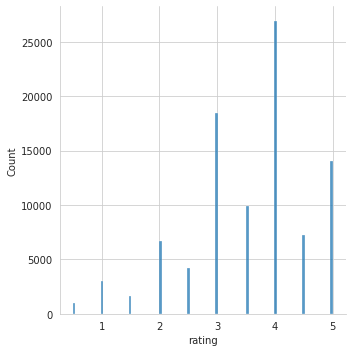

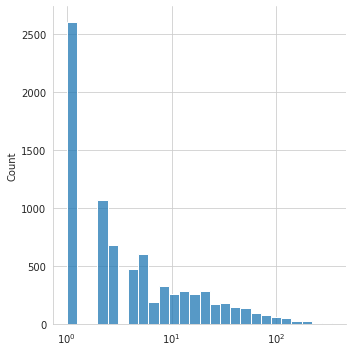

In [72]:
sns.displot(train.rating, height=5);
sns.displot(train.groupby('movieId').size(), log_scale=True, height=5);

Поскольку датасет очень маленький, позволим себе обучить ALS с обращением матриц.

In [47]:
def ALS(users: List, items: List, ratings: List, num_users: int, num_items: int, dim=64, n_iters=1, eps=1e-7):
    R = csr_matrix((ratings, (users, items)), shape=(num_users, num_items))
    P = np.random.randn(num_users, dim)
    Q = np.random.randn(num_items, dim)
    
    for t in tqdm(range(n_iters)):
        RQ = R @ Q
        for u in range(num_users):
            relevant_items = items[users == u]
            Q_rel = Q[relevant_items]
            QQ = Q_rel.reshape(-1, dim, 1) * Q_rel.reshape(-1, 1, dim)
            P[u] = np.linalg.inv(QQ.sum(axis=0) + eps * np.eye(dim)) @ RQ[u]

        RP = R.T @ P
        for i in range(num_items):
            relevant_users = users[items == i]
            P_rel = P[relevant_users]
            PP = P_rel.reshape(-1, dim, 1) * P_rel.reshape(-1, 1, dim)
            Q[i] = np.linalg.inv(PP.sum(axis=0) + eps * np.eye(dim)) @ RP[i]
    
    return P, Q

In [60]:
P, Q = ALS(train.userId, train.movieId, train.rating, num_users, num_movies, n_iters=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.26s/it]


Сгенерируем предсказания, посчитав скалярные произведения между векторами пользователей и фильмов.

In [61]:
train_preds = (P[train.userId] * Q[train.movieId]).sum(axis=1)
test_preds = (P[test.userId] * Q[test.movieId]).sum(axis=1)
# для удобства можно отнормирвоать предсказания в шкалу оценок
test_preds = np.clip(test_preds, 0.0, 5.0)

И нужно выбрать какую-то метрику для оценки качества. Мы предсказывали explicit рейтинги, давайте возьмем $R^2$, почему нет. 

In [62]:
print(f'Train R^2: {r2_score(train.rating, train_preds):.4f}')
print(f'Test R^2: {r2_score(test.rating, test_preds):.4f}')

Train R^2: 0.9639
Test R^2: -2.6522


Кстати, в каких случаях $R^2$ получается отрицательным?

Может показаться, чот результаты получились из ряда вон плохие. Однако не стоит забывать, что нас интересуют не сами предсказания рейтингов, а рекомендации новых фильмов. Отсортируем предсказанные фильмы по оценкам прогнозов, т.е. значениям скалярных произведений, и посчитаем какую-нибудь метрику для ранжирования — MAP@k. Пусть $k=10$, например, потому что длина подборки из рекомендаций на сайте онлайн кинотеатра равна 10. Чтобы нам было с чем сравнивать, посчитаем еще рекомендацию из 10 случайных фильмов и Top Popular по рейтингам фильмов. 

In [56]:
def remove_train_items(preds, k):
    new_preds = np.zeros((preds.shape[0], k), dtype=np.int)
    for user, data in train.groupby('userId'):
        user_preds = preds[user]
        new_preds[user] = user_preds[~np.in1d(user_preds, data.movieId)][:k]
    return new_preds


def get_ALS_preds(U, V, k=10):
    preds = np.argsort(U @ V.T, axis=1)
    preds = remove_train_items(preds, k)
    return preds


def get_random_preds(k=10):
    preds = np.tile(np.arange(num_movies), (num_users, 1))
    for i in range(num_users):
        rand_perm = np.random.permutation(num_movies)
        preds[i] = preds[i][rand_perm]

    preds = remove_train_items(preds, k)
    return preds

def get_toppop_preds(freq=10, k=10):
    mean_rating = train.groupby('movieId').rating.mean()
    mean_rating = mean_rating[train.groupby('movieId').size() >= freq]
    preds = np.array(mean_rating.sort_values(ascending=False).index)
    preds = np.tile(preds, (num_users, 1))
    preds = remove_train_items(preds, k)
    return preds


def MAP_k(y_true, y_pred, k=10):
    map_k, count = 0, 0
    for relevant, predicted in zip(y_true, y_pred):
        if not relevant:
            continue
        correct = np.isin(predicted[:k], relevant)
        map_k += (correct / np.arange(1, k + 1)).sum() / (1 / np.arange(1, len(relevant) + 1)).sum()
        count += 1
    map_k = map_k / count
    return map_k

Посчитаем значение MAP@k для разных значений k.

In [69]:
true_relevant = []
for user, data in test[test.rating >= 3.0].groupby('userId'):
    true_relevant += [data.movieId.tolist()]

In [70]:
ks = np.arange(1, 31)
als_preds = get_ALS_preds(P, Q, k=ks[-1])
random_preds = get_random_preds(k=ks[-1])
top_preds = get_toppop_preds(freq=10, k=ks[-1])

random_map_k = [MAP_k(true_relevant, random_preds, k=k) for k in ks]
top_map_k = [MAP_k(true_relevant, top_preds, k=k) for k in ks]
als_map_k = [MAP_k(true_relevant, als_preds, k=k) for k in ks]

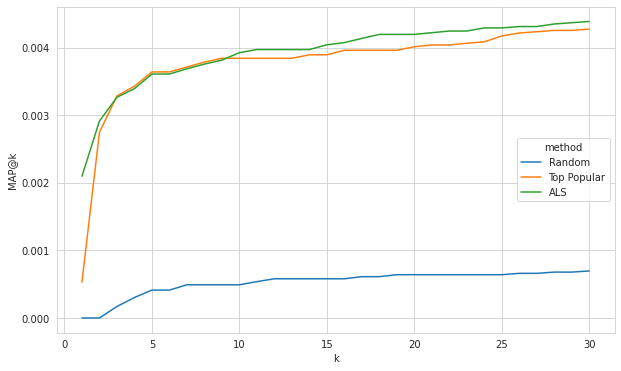

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(ks, random_map_k, label='Random')
plt.plot(ks, top_map_k, label='Top Popular')
plt.plot(ks, als_map_k, label='ALS')

plt.legend(title='method')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

Источники:

1. https://developers.google.com/machine-learning/recommendation/collaborative/summary 
2. https://github.com/esokolov/ml-course-hse/blob/master/2021-spring/seminars/sem24-recommendations.pdf
3. https://github.com/esokolov/ml-course-hse/blob/master/2021-spring/seminars/sem24-recommendations.ipynb
4. https://github.com/esokolov/ml-course-hse/blob/master/2021-spring/homeworks-practice/homework-practice-13-recommendations/homework-practice-13-recommendations.ipynb
